## **Establish Parker Observatory Time-Lapse Video Stream**

> This Jupyter Notebook executes a data pipeline against the Parker Solar Observatory image repository.  
> The script initially scrapes the provided base URL for sub-folders,  
> and then directs to the User Interface selected date as its input constraint.  
>  
> Once the specified sub-folder is accessed in this way,  
> its file contents are exposed and the final FITS file artifact is captured as a file path into a DataFrame.  
>  
> Then, the User Interface specified date selection is captured to fecth the DataFrame URL obnjects,  
> that are then saved as PNG image files, before then compiling those as frames into a GIF file format.  
>  
> This GIF is then returned to the calling User Interface location within the app.  



NOTE: this script currently fails when FITS images are transformed using NormLog function, for when vmin==vmax.

> **DATA SOURCE**  
>>     WIDE-FIELD IMAGER FOR PARKER SOLAR PROBE (WISPR) - WISPR DATA  
>  
> **REFERENCE**  
>>     https://wispr.nrl.navy.mil/data/rel/fits/L3/

## **Python Libraries**

In [65]:
# import Python libraries
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style

from bs4 import BeautifulSoup
import requests

from matplotlib.colors import LogNorm

import imageio
from pathlib import Path

import os
import numpy as np



## **Fetch Specified Data Set**

In [54]:
# return basic url html
# option to select various level of processing
url = 'https://wispr.nrl.navy.mil/data/rel/fits/L3/orbit12/'   #most recent orbital data
# url = 'https://wispr.nrl.navy.mil/data/rel/fits/L2/'   #most recent orbital data
# url = 'https://wispr.nrl.navy.mil/data/rel/fits/L1/'   #most recent orbital data

# url = 'https://wispr.nrl.navy.mil/data/rel/fits/CAL1/'   #most recent orbital data
# url = 'https://wispr.nrl.navy.mil/data/rel/fits/CAL1/L2b/orbit12/'

req = requests.get(url)

# return an html parser object
soup_top = BeautifulSoup(req.content, 'html.parser') 



In [55]:
# string substitution for html
# ref: https://stackoverflow.com/questions/41063019/python-web-scraping-page-loop

# return a list of sub-folders to drill-down
lst_children = []
for link in soup_top.findAll('a'):
    val = link.get("href")   #return sub-folder string
    if ('?' in val): pass
    elif ('/data/' in val): pass
    elif ('highcadence/' in val): pass
    else:
        lst_children.append(val)   #update the list

print('Total Dates to Choose: {}'.format(len(lst_children)))
print('min:\t{}'.format(lst_children[0]))
print('max:\t{}'.format(lst_children[len(lst_children)-1]))



Total Dates to Choose: 26
min:	20220515/
max:	20220609/


In [56]:
'''
INPUT: UI selected date
'''
#return the chosen date
# date is selected on UI
child_select = lst_children[4]
print(child_select)

# RETURN: html parsed data for sub-folder contents to scrape
def get_soup_child(url, child):
    url = url + child
    req = requests.get(url)

    # return an html parser object
    soup_child = BeautifulSoup(req.content, 'html.parser')
    
    return soup_child, url

soup_child, url = get_soup_child(url, child_select)



20220519/


In [57]:
#return contents of folder
print('Processing FITS FILES for \'{}\''.format(child_select[:-2]))

lst_targets = []
for link in soup_child.findAll('a'):
    val = link.get("href")   #return sub-folder string
    
    if (not '?' in val) and (not '/data/' in val):     #strip header data
        lst_targets.append(url + val)
    
df_FITS = pd.DataFrame(data=lst_targets, columns=['fits_target_path'])
print('Total Records:\t{}'.format(len(df_FITS)))

    

Processing FITS FILES for '2022051'
Total Records:	45


## **Extract FITS Data**

In [58]:
#set the matplotlib style
plt.style.use(astropy_mpl_style)



ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x000001A5AAABF8B0> (for post_execute):


ValueError: Invalid vmin or vmax

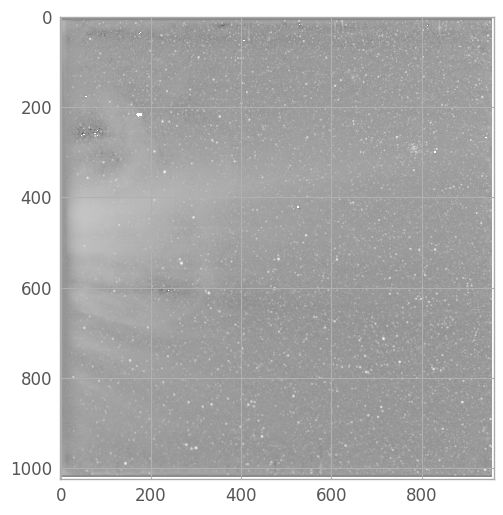

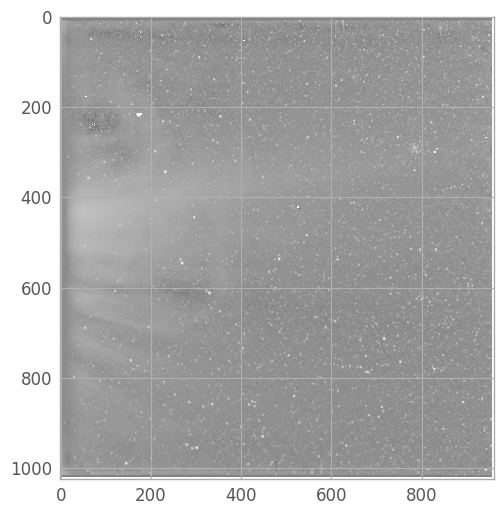

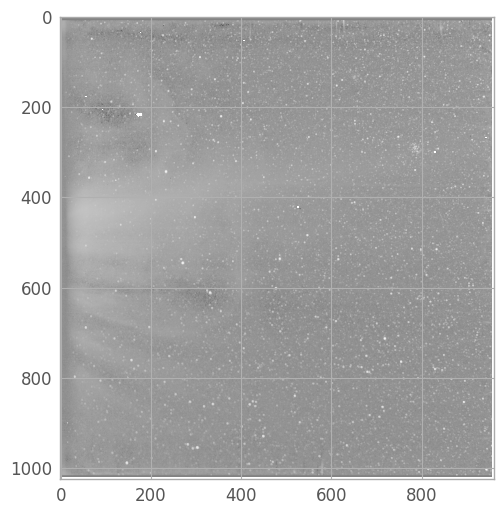

ValueError: Invalid vmin or vmax

<Figure size 800x600 with 1 Axes>

In [90]:
#return INFO for each FITS file
for target in lst_targets:
    arr_new = np.empty(0)
    #save the plot as PNG format
    parsed_filename = target.split('/')
    file = parsed_filename[9].split('.')[0]
    filepath = './artifacts/WISPR/' + file + '.png'

    # handle the possible error state where array list-elements contain all NaNs
    # from within the target file
    image_data = fits.getdata(target, ext=0)
    # flag_nans = False
    count = 0
    for i in image_data:
        if (np.isnan(i).all()):
            pass
        else:
            arr_new = np.append(arr_new, i)
            # print(arr_new)
        count += 1
            
    plt.figure()
    plt.imshow(image_data, cmap='gray', norm='logit')
    plt.savefig(filepath)   #save as PNG



In [ ]:
# REF:    https://medium.com/swlh/python-animated-images-6a85b9b68f86
# TITLE:  Create Animated Images Using Python
# RETURN: GIF file to execute
image_path = Path('./artifacts/WISPR')
images = list(image_path.glob('*.png'))

image_list = []
for file_name in images:
    print(file_name)
    image_list.append(imageio.imread(file_name))
    



In [ ]:
#return the created GIF
imageio.mimwrite('./artifacts/WISPR/parker_animated.gif', image_list)

#clean-up source image files
for file_name in images:
    os.remove(file_name)
    


In [ ]:
print('=============================')
print('       END OF SCRIPT')
print('=============================')

